In [137]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn

# EDA

In [138]:
image_dir = Path('../input/age-prediction/20-50/20-50') #tell python in which directory the training images are.
# filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
# ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)
# images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
# images.head()

In [139]:
def preprocessing(image_dir):
    filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
    ages = filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]).astype(np.int16) # 파일경로에서 나이 추출

    ranged_ages = []
    for age in ages:
        if 20 <= age <= 24:
            ranged_ages.append('20-24')
        elif 25 <= age <= 29:
            ranged_ages.append('25-29')
        elif 30 <= age <= 34:
            ranged_ages.append('30-34')
        elif 35 <= age <= 39:
            ranged_ages.append('35-39')
        elif 40 <= age <= 44:
            ranged_ages.append('40-44')
        elif 45 <= age <= 50:
            ranged_ages.append('45-50')

    s_ages = pd.Series(ranged_ages, name='Age').astype(str)
    images = pd.concat([filepaths, s_ages], axis=1).sample(frac=1).reset_index(drop=True)
    
    return images

In [140]:
images = preprocessing(image_dir)
images.head()

,Filepath,Age
0,../input/age-prediction/20-50/20-50/train/25/1...,25-29
1,../input/age-prediction/20-50/20-50/test/41/40...,40-44
2,../input/age-prediction/20-50/20-50/test/25/39...,25-29
3,../input/age-prediction/20-50/20-50/train/36/1...,35-39
4,../input/age-prediction/20-50/20-50/train/40/1...,40-44


In [141]:
from sklearn.preprocessing import LabelEncoder
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# train 데이터프레임의 'Age' 열을 라벨 인코딩
images['Age_encoded'] = label_encoder.fit_transform(images['Age'])
images

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,Filepath,Age,Age_encoded
0,../input/age-prediction/20-50/20-50/train/25/1...,25-29,1
1,../input/age-prediction/20-50/20-50/test/41/40...,40-44,4
2,../input/age-prediction/20-50/20-50/test/25/39...,25-29,1
3,../input/age-prediction/20-50/20-50/train/36/1...,35-39,3
4,../input/age-prediction/20-50/20-50/train/40/1...,40-44,4
...,...,...,...
40435,../input/age-prediction/20-50/20-50/train/35/1...,35-39,3
40436,../input/age-prediction/20-50/20-50/train/44/1...,40-44,4
40437,../input/age-prediction/20-50/20-50/train/36/1...,35-39,3
40438,../input/age-prediction/20-50/20-50/train/34/1...,30-34,2


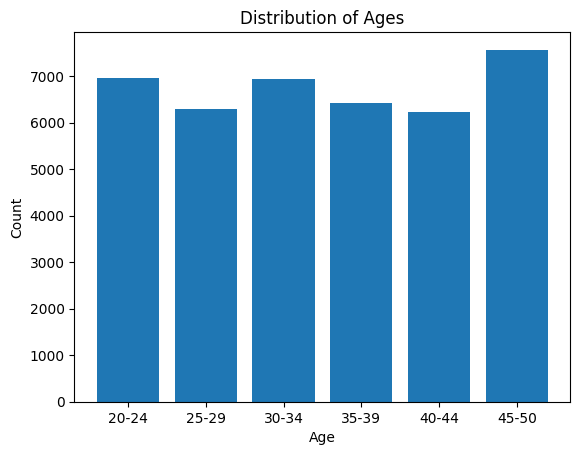

In [142]:
# 나이에 대한 빈도수 계산
age_counts = images['Age'].value_counts().sort_index()

# 막대그래프로 시각화
plt.bar(age_counts.index, age_counts.values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')
plt.show()

Age: 40-44


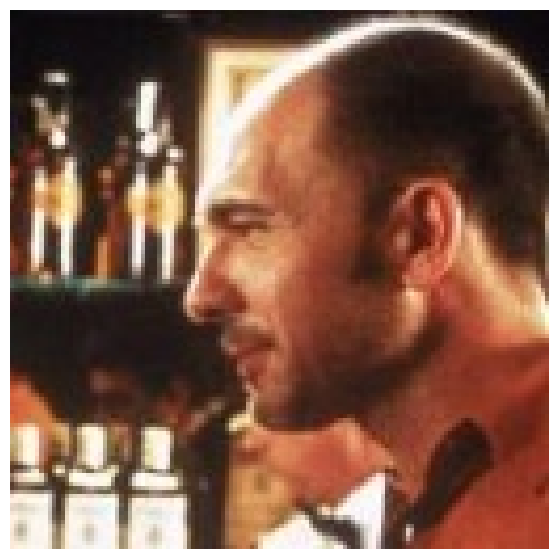

In [143]:
def visualize(image):
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(image)

#choose an image id to see its age
image_id = 35
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

# Prepare Data

In [145]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, test_size = 0.1, random_state = 1)
train, valid = train_test_split(train, test_size = 0.2, random_state = 1)

## Dataset class

In [146]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import cv2
import numpy as np

class ImageAgeDataset(Dataset):
    def __init__(self, images, transform=None):
        self.age = images.Age_encoded.values
        self.paths = images.Filepath.values
        self.transform = transform

    def __len__(self):
        return len(self.age)

    def __getitem__(self, item):
        out = dict()
        path = self.paths[item]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255 
        out['y'] = torch.tensor(self.age[item], dtype=torch.long)
        return out

# 이미지 데이터를 위한 변환 정의
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [147]:
# class ImageAgeDataset() : 
#   def __init__(self , images) : 
#     self.age = images.Age.values
#     self.paths = images.Filepath.values 

#   def __len__(self) : 
#     return len(self.age)

#   def __getitem__(self , item) : 
#     out = dict()
#     path = self.paths[item] 
#     image = cv2.imread(path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = np.array(image , dtype = float)
#     out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255 
#     out['y'] = torch.tensor(self.age[item], dtype= torch.long) #CrossEntropyLoss()'s forward(probs, y) function requires torch.long for y
#     return out 

In [148]:
train_dataset = ImageAgeDataset(train) 
valid_dataset = ImageAgeDataset(valid)

# Model

In [149]:
from torch import Tensor

class BasicBlock(nn.Module):
    expansion_factor = 1
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))
                
    def forward(self, x: Tensor) -> Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x += self.residual(out)
        x = self.relu2(x)
        return x

In [150]:
class BottleNeck(nn.Module):
    expansion_factor = 4
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BottleNeck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion_factor, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion_factor)
        
        self.relu3 = nn.ReLU()
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))
        
    def forward(self, x:Tensor) -> Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        x += self.residual(out)
        x = self.relu3(x)
        return x

In [151]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.conv2 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.conv3 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512 * block.expansion_factor, num_classes)

        self._init_layer()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion_factor
        return nn.Sequential(*layers)

    def _init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [152]:
class Model:
    def resnet18(self):
        return ResNet(BasicBlock, [2, 2, 2, 2])

    def resnet34(self):
        return ResNet(BasicBlock, [3, 4, 6, 3])

    def resnet50(self):
        return ResNet(BottleNeck, [3, 4, 6, 3])

    def resnet101(self):
        return ResNet(BottleNeck, [3, 4, 23, 3])

    def resnet152(self):
        return ResNet(BottleNeck, [3, 8, 36, 3])

# Engine

In [153]:
#hparams
DEVICE = 'cuda' 
BATCH_SIZE = 50
MAX_WAIT = 3
EPOCHS = 100
LR = 1e1

#---------------------
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = True ,
    num_workers = 8
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    num_workers = 8
)
#---------------------
model = model = Model().resnet34()
model.to(DEVICE)
#---------------------
loss_fn = nn.CrossEntropyLoss()
#---------------------
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
#---------------------
from tqdm.notebook import tqdm 
import numpy as np 
def train_step(model , optimizer , dataloader): 
  model.train()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    y_hat = model(x).to(DEVICE) #to apply model(x), x and model must be in the same place (device)
    loss = loss_fn(y_hat , y) #enough for y_hat and y to be in the same device
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  #total_loss.backward()
  #optimizer.step()
  #optimizer.zero_grad()
  return total_loss/len(dataloader)

def valid_step(model, dataloader): 
  model.eval()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    with torch.no_grad():
      y_hat = model(x).to(DEVICE)
      loss = loss_fn(y_hat , y) 
    total_loss += loss.item()
  return total_loss/len(dataloader)

def main(model , optimizer , train_dataloader , valid_dataloader ): 
  train_losses = []
  valid_losses = [] 
  min_valid_loss = np.inf 
  patience = 0 
  for epoch in range(EPOCHS): 
    train_loss = train_step(model , optimizer , train_dataloader)
    train_losses.append(train_loss)  
    valid_loss = valid_step(model , valid_dataloader)
    valid_losses.append(valid_loss)
    print(f'EPOCH = {epoch}')
    print(f'train_loss = {train_loss}')
    print(f'valid_loss = {valid_loss}')
    if valid_loss > min_valid_loss : 
      patience += 1 
    else: 
      min_valid_loss = valid_loss 
      patience = 0 

    if patience > MAX_WAIT : 
      print(f'EARLY STOPPING AT EPOCH = {epoch}')
      break 
  return train_losses , valid_losses 
        

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [154]:
train_losses, valid_losses = main(
    model = model, 
    optimizer = optimizer, 
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader
)

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 292.6811160981962
valid_loss = 16.264338145517325


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 2.2605925088885717
valid_loss = 6.7744157379620695


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 2.297204477913793
valid_loss = 2.943939395963329


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 2.217397801054076
valid_loss = 37.538295767895164


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 4
train_loss = 2.311107081982529
valid_loss = 5.536684789069711


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 5
train_loss = 452.65060052781735
valid_loss = 2.598917704738983


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 6
train_loss = 2.2020208502306535
valid_loss = 2.617428577926061


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 7
train_loss = 2.229231813146156
valid_loss = 1.9513095347848657


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 8
train_loss = 2.1927020733802234
valid_loss = 2.81021190832739


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 9
train_loss = 2.260094144945488
valid_loss = 2.28440513267909


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 10
train_loss = 2.3254977350169552
valid_loss = 1.992787722855398


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 11
train_loss = 2.242233336483021
valid_loss = 2.3737770906866413
EARLY STOPPING AT EPOCH = 11


In [155]:
test_dataset = ImageAgeDataset(test)

In [156]:
len(test_dataset)

4044

In [157]:
age_labels = {'20-24' : 0, '25-29' : 1, '30-34' : 2, '35-39' : 3, '40-44' : 4, '45-50': 5}
inverse_age_labels = {v: k for k, v in age_labels.items()}


In [160]:
def pred(x):
    for i in range(len(x[0])):
        if (x[0][i] == torch.max(x[0]).item()): 
            return i

In [161]:
from sklearn.metrics import accuracy_score

# 예측을 저장할 리스트
predictions = []

# 실제 레이블을 저장할 리스트
true_labels = []

# 모델을 평가할 데이터셋 선택 (여기서는 test_dataset을 사용)
eval_dataset = test_dataset

# 평가 데이터셋에 대해 예측 수행
for i in range(len(eval_dataset)):
    x = eval_dataset[i]['x'].unsqueeze(0).to(DEVICE)  # 배치 차원 추가
    y = eval_dataset[i]['y'].item()  # 정수 형태의 라벨
    y_hat = model(x)
    
    # 예측값 저장
    predictions.append(pred(softmax(y_hat)))
    
    # 실제 레이블 저장
    true_labels.append(y)

# 정확도 계산
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

/tmp/ipykernel_47/2522587414.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions.append(pred(softmax(y_hat)))


Accuracy: 19.41%


In [162]:
from torchvision import transforms
ws_df = pd.DataFrame({'Filepath':['/kaggle/input/wonseok2/leewonseok.jpg', '/kaggle/input/lee1seok/leewonseok2.jpg', '/kaggle/input/lee1seok/leewonseok3.jpg'],
                             'Age_encoded':[0, 0, 0]})

# CustomDataset 인스턴스 생성
my_dataset = ImageAgeDataset(ws_df, transform=transform)

In [163]:
my_dataset[1]['x'].transpose(0, 1).shape

/tmp/ipykernel_47/1823485844.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255


torch.Size([3, 224, 224])

In [164]:
test_dataset[id]['x'].shape

torch.Size([3, 128, 128])

In [165]:
# y_hat_id = softmax(model(my_dataset[id]['x'].to(DEVICE)))
# true_age = my_dataset[id]['y'].item()
# true_age = inverse_age_labels.get(man_age, None)
# print(f'image {id} is {true_age} years old and is predicted {inverse_age_labels.get(pred(y_hat_id), None)} years old')
# image = cv2.imread(ws_df.iloc[id].Filepath)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# visualize(image)